In [1]:
# nltk.download('stopwords')

In [43]:
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616160;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [4]:
# Gensim
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, Phrases
from gensim.models.phrases import Phraser
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [5]:
# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from nltk.corpus import stopwords
from nltk import Tree

stop_words = stopwords.words('english')

In [7]:
df = pd.read_csv("data_10050.csv")

In [8]:
data = df['Metadata'].dropna().tolist()

In [9]:
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

<>:2: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \s
/var/folders/fd/qmhdtpdj7kj77ftrqfj87hmc0000gn/T/ipykernel_52849/1419459543.py:2: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
/var/folders/fd/qmhdtpdj7kj77ftrqfj87hmc0000gn/T/ipykernel_52849/1419459543.py:5: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [11]:
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

def remove_stopwords_mult(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
bigram = Phrases(data_words, min_count=20, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

data_words_nostops_2 = remove_stopwords_mult(data_words)
data_with_phrases = [trigram_mod[bigram_mod[doc]] for doc in data_words_nostops_2]
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_with_phrases, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
#id2word.filter_extremes(no_below=20, no_above=0.5) # brings down unique tokens from 80 thousand to 12

# Create Corpus
texts = data_lemmatized#data_with_phrases

# Term Frequency list   
corpus = [id2word.doc2bow(text) for text in texts] 

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_with_phrases)
id2word.filter_extremes(no_below=20, no_above=0.5) # brings down unique tokens from 80 thousand to 12

# Create Corpus
texts = data_with_phrases

# Term Frequency list   
corpus = [id2word.doc2bow(text) for text in texts] 

In [15]:
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [33]:
# Build LDA model

# increased chunk size to speed up development
# LdaMulticoreModel had slower training time, would have otherwise used it 

lda_model = LdaModel(corpus=corpus,
                id2word=id2word,
                num_topics=5, 
                random_state=100,
                update_every=1,
                chunksize=2000,
                passes=10,
                alpha='auto',
                eta='auto',
                per_word_topics=True)

In [34]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 1305
Number of documents: 9333


In [35]:
# Check the type of the numbers in the LDA topics
for topic in lda_model.print_topics():
    for word, prob in lda_model.show_topic(topic[0]):
        if isinstance(prob, complex):
            print(f"Complex number found in topic {topic[0]} for word '{word}'")

In [36]:
# Print the Keyword
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.041*"killed" + 0.023*"news" + 0.023*"de" + 0.017*"rebels" + 0.017*"soldiers" + 0.014*"said" + 0.013*"army" + 0.013*"attack" + 0.012*"two" + 0.011*"people"'), (1, '0.013*"news" + 0.013*"country" + 0.012*"president" + 0.012*"government" + 0.011*"nytimes_com" + 0.009*"crisis" + 0.009*"facts" + 0.008*"iran" + 0.008*"war" + 0.008*"military"'), (2, '0.041*"war" + 0.026*"history" + 0.024*"conflict" + 0.015*"reuters_com" + 0.014*"civil" + 0.011*"violence" + 0.011*"afghanistan" + 0.010*"africa" + 0.010*"south" + 0.009*"world"'), (3, '0.108*"wikipedia" + 0.054*"international" + 0.051*"refworld" + 0.045*"moment" + 0.036*"information" + 0.031*"network" + 0.030*"regional" + 0.027*"countries" + 0.026*"positions" + 0.025*"institutions"'), (4, '0.078*"rights" + 0.072*"human" + 0.036*"news" + 0.030*"report" + 0.019*"watch" + 0.015*"world" + 0.013*"latest" + 0.013*"amnesty_international" + 0.013*"state" + 0.010*"un"')]


In [37]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [38]:
try:
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
except Exception as e:
    print(f"Error preparing LDA visualization: {e}")

In [39]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.150334  0.024158       1        1  28.305965
0      0.150510  0.255580       2        1  23.024775
2      0.108874 -0.107648       3        1  22.796233
4      0.000779 -0.245630       4        1  17.734736
3     -0.410496  0.073540       5        1   8.138292, topic_info=                          Term         Freq        Total Category  logprob  \
293                     rights  1411.000000  1411.000000  Default  30.0000   
282                      human  1315.000000  1315.000000  Default  29.0000   
3                    wikipedia   904.000000   904.000000  Default  28.0000   
9                       killed   970.000000   970.000000  Default  27.0000   
115              international   757.000000   757.000000  Default  26.0000   
...                        ...          ...          ...      ...      ...   
115              international   451.461456   757.598377   Topic5  -2.9167   
237                  countries   224.385703   360.277783   Topic5  -3.6158   
1170  central_african_republic    56.981049    70.412210   Topic5  -4.9864   
140                       list    82.694101   145.248088   Topic5  -4.6140   
235                 chronology    50.545742   109.066750   Topic5  -5.1063   

      loglift  
293   30.0000  
282   29.0000  
3     28.0000  
9     27.0000  
115   26.0000  
...       ...  
115    1.9909  
237    2.0351  
1170   2.2969  
140    1.9453  
235    1.7395  

[295 rows x 6 columns], token_table=      Topic      Freq                     Term
term                                          
349       4  0.988183                   abuses
913       4  0.992066  academic_journals_books
0         3  0.989907                   afghan
25        2  0.063644              afghanistan
25        3  0.928450              afghanistan
...     ...       ...                      ...
77        1  0.452702                    years
77        2  0.127034                    years
77        3  0.418056                    years
1194      1  0.987948                   zambia
1007      3  0.980972                 zimbabwe

[432 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 5, 4])

In [23]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -6.739217439388752


In [24]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_with_phrases, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.45235466643160305


## Find optimzed number of topics

In [29]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=10, step=5):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = LdaModel(corpus=corpus,
                    id2word=id2word,
                    num_topics=num_topics, 
                    random_state=100,
                    update_every=1,
                    chunksize=2000,
                    passes=10,
                    alpha='auto',
                    eta='auto',
                    per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [30]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_with_phrases, start=5, limit=30, step=5)

5
10
15
20
25


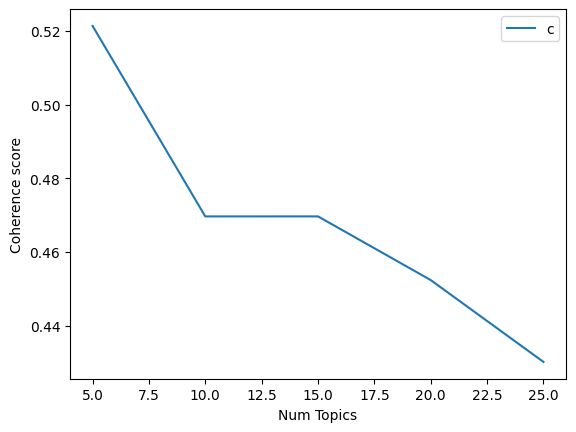

In [31]:
limit=30; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [40]:
optimal_model = lda_model

In [32]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.5213
Num Topics = 10  has Coherence Value of 0.4696
Num Topics = 15  has Coherence Value of 0.4696
Num Topics = 20  has Coherence Value of 0.4524
Num Topics = 25  has Coherence Value of 0.4302


In [41]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=data):
    #sent_topics_df = pd.DataFrame()
    top_list = []

    # Get main topic in each document
    for i, row in enumerate(list(ldamodel[corpus])):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Percent Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                top_list.append([int(topic_num), round(prop_topic,4), topic_keywords])
            else:
                break
    sent_topics_df = pd.DataFrame(top_list, columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
    
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [1]:
original_df = pd.read_csv("../aed.csv")

NameError: name 'pd' is not defined

In [42]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               2              0.6618   
1            1               1              0.2798   
2            2               0              0.9103   
3            3               1              0.4735   
4            4               2              0.9525   
5            5               2              0.9599   
6            6               2              0.4650   
7            7               2              0.4844   
8            8               2              0.9498   
9            9               2              0.6618   

                                            Keywords  \
0  war, history, conflict, reuters_com, civil, vi...   
1  news, country, president, government, nytimes_...   
2  killed, news, de, rebels, soldiers, said, army...   
3  news, country, president, government, nytimes_...   
4  war, history, conflict, reuters_com, civil, vi...   
5  war, history, conflict, reuters_com, civil, vi...   
6  war, history, conflict, reuters_com, civil, vi...   
7  war, history, conflict, reuters_com, civil, vi...   
8  war, history, conflict, reuters_com, civil, vi...   
9  war, history, conflict, reuters_com, civil, vi...   

                                                Text  
0           Afghan Civil War (1989–1992) - Wikipedia  
1   CC BY-SA 3.0 Deed | Attribution-ShareAlike 3....  
2   At least 41 killed in rebel attack on Ugandan...  
3  The Soviet Withdrawal from Afghanistan 1989 | ...  
4  What Happened When The Soviets Left Afghanista...  
5  Defeat of the Soviet Union in Afghanistan - Th...  
6  Afghan War | History, Casualties, Dates, & Fac...  
7  Afghanistan War - Key Events, Facts & Combatan...  
8  The Afghan Civil War (1978-Present) - A histor...  
9           Afghan Civil War (1992–1996) - Wikipedia